In [1]:
# ライブラリ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import init

from functools import partial
import matplotlib.pyplot as plt


In [19]:
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    """
    Train and validate a given PyTorch model.
    
    Parameters:
    - model: PyTorch model to train. Model needs to be on GPU beforehand if it's supposed to be trained on GPU.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - optimizer: PyTorch optimizer.
    - loss_func: PyTorch loss function.
    - num_epoch: Number of epochs for training.
    - early_stopping: Number of epochs with no improvement to stop training. None means no early stopping.
    - save_path: Path to save the best model.
    - scheduler: Learning rate scheduler. None means no scheduler.
    
    Returns:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - val_accuracies: List of validation accuracies.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数
    
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        
        for train_batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
            
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            optimizer.step()
            
        model.eval()
        # validation
        with torch.no_grad():
            for val_batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
                X_val, y_val = data
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies

In [5]:
# MNISTのデータを準備
# PIL -> tensor, 正規化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True,transform=transform )
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)

X_train, y_train = next(iter(train_loader))
X_train.shape

Using downloaded and verified file: ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 10850563.76it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 14902818.56it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6147314.87it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



torch.Size([128, 1, 28, 28])

In [37]:
# 簡易的なモデルを作成する
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),

    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    # 32x2x2
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(32, 10),

)

In [38]:
# CPUかGPUかを確認する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conv_model = conv_model.to(device)


In [39]:
optimizer = optim.SGD(conv_model.parameters(), lr=0.4)
loss_func = F.cross_entropy
num_epoch = 10

train_losses, val_losses, val_accuracies = learn(conv_model, train_loader, val_loader, optimizer, loss_func, num_epoch)


epoch: 0: train error: 0.24329848522379963, validation error: 0.1726186438168906, validation accuracy: 0.9457080696202531


epoch: 1: train error: 0.08850973616562673, validation error: 0.07100059919035699, validation accuracy: 0.977254746835443


KeyboardInterrupt: 

In [ ]:
# activationの可視化

# hookを使ってActivationの情報を取得する

In [ ]:

class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))
        

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))
        
        plt.show()

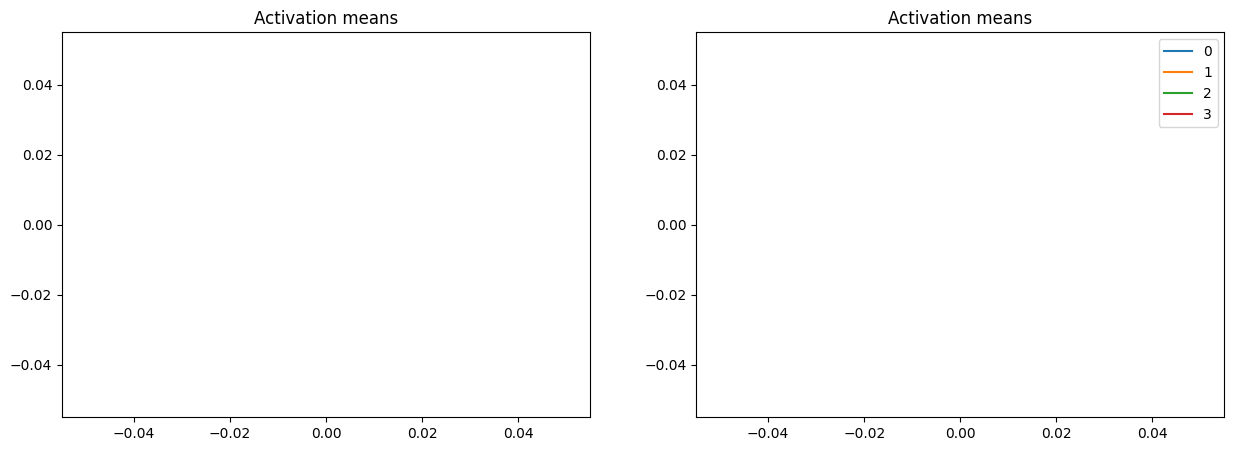

In [ ]:
act_stats = ActivationStatistics(conv_model)
act_means, act_stds = act_stats.get_statstics()
act_stats.plot_statistics()